<a href="https://colab.research.google.com/github/hgene0929/deep_learning/blob/main/segmentation_test_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir /content/data

In [ ]:
!mkdir ./pretrained
!wget -O ./pretrained/mask_rcnn_inception_v2_coco_2018_01_28.tar.gz http://download.tensorflow.org/models/object_detection/mask_rcnn_inception_v2_coco_2018_01_28.tar.gz
!wget -O ./pretrained/config_mask_graph.pbtxt https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt

In [ ]:
!tar -xvf ./pretrained/mask*.tar.gz -C ./pretrained 

In [83]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [84]:
# coco dataset의 클래스 ID별 클래스명 매핑
labels_to_names_seq= {0:'person',1:'bicycle',2:'car',3:'motorcycle',4:'airplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',
                    10:'fire hydrant',11:'street sign',12:'stop sign',13:'parking meter',14:'bench',15:'bird',16:'cat',17:'dog',18:'horse',19:'sheep',
                    20:'cow',21:'elephant',22:'bear',23:'zebra',24:'giraffe',25:'hat',26:'backpack',27:'umbrella',28:'shoe',29:'eye glasses',
                    30:'handbag',31:'tie',32:'suitcase',33:'frisbee',34:'skis',35:'snowboard',36:'sports ball',37:'kite',38:'baseball bat',39:'baseball glove',
                    40:'skateboard',41:'surfboard',42:'tennis racket',43:'bottle',44:'plate',45:'wine glass',46:'cup',47:'fork',48:'knife',49:'spoon',
                    50:'bowl',51:'banana',52:'apple',53:'sandwich',54:'orange',55:'broccoli',56:'carrot',57:'hot dog',58:'pizza',59:'donut',
                    60:'cake',61:'chair',62:'couch',63:'potted plant',64:'bed',65:'mirror',66:'dining table',67:'window',68:'desk',69:'toilet',
                    70:'door',71:'tv',72:'laptop',73:'mouse',74:'remote',75:'keyboard',76:'cell phone',77:'microwave',78:'oven',79:'toaster',
                    80:'sink',81:'refrigerator',82:'blender',83:'book',84:'clock',85:'vase',86:'scissors',87:'teddy bear',88:'hair drier',89:'toothbrush',
                    90:'hair brush'}



#masking 시 클래스별 컬러 적용
colors = list(
    [[0, 255, 0],
     [0, 0, 255],
     [255, 0, 0],
     [0, 255, 255],
     [255, 255, 0],
     [255, 0, 255],
     [80, 70, 180],
     [250, 80, 190],
     [245, 145, 50],
     [70, 150, 250],
     [50, 190, 190]] )

In [157]:
img = cv2.imread('./data/car_img1.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img2 = cv2.imread('./data/car_img1.jpg')
img_rgb2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

In [158]:
cv_net = cv2.dnn.readNetFromTensorflow('./pretrained/mask_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb', './pretrained/config_mask_graph.pbtxt')
blob = cv2.dnn.blobFromImage(img , swapRB=True, crop=False)
cv_net.setInput(blob)

# Bounding box 정보는 detection_out_final layer에서 mask 정보는 detection_masks layer에서 추출. 
boxes, masks = cv_net.forward(['detection_out_final', 'detection_masks'])

cv_net2 = cv2.dnn.readNetFromTensorflow('./pretrained/mask_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb', './pretrained/config_mask_graph.pbtxt')
blob2 = cv2.dnn.blobFromImage(img2 , swapRB=True, crop=False)
cv_net2.setInput(blob2)

# Bounding box 정보는 detection_out_final layer에서 mask 정보는 detection_masks layer에서 추출. 
boxes2, masks2 = cv_net2.forward(['detection_out_final', 'detection_masks'])

In [159]:
numClasses = masks.shape[1]
numDetections = boxes.shape[2]

# opencv의 rectangle(), putText() API는 인자로 들어온 IMAGE array에 그대로 수정작업을 수행하므로 bounding box 적용을 위한 
# 별도의 image array 생성. 
draw_img = img_rgb.copy()

img_height = draw_img.shape[0]
img_width = draw_img.shape[1]

conf_threshold = 0.5
mask_threshold = 0.3

# 이미지를 mask 설명을 위해서 iteration을 한번만 수행. 
#for i in range(numDetections):
for i in range(1):
    box = boxes[0, 0, i]
    mask = masks[i]
    score = box[2]
    if score > conf_threshold:
        classId = int(box[1])
        left = int(img_width * box[3])
        top = int(img_height * box[4])
        right = int(img_width * box[5])
        bottom = int(img_height * box[6])

        text = "{}: {:.4f}".format(labels_to_names_seq[classId], score)
        #cv2.rectangle(draw_img, (left, top), (right, bottom), green_color, thickness=2 )
        #cv2.putText(draw_img, text, (left, top-3), cv2.FONT_HERSHEY_SIMPLEX, 0.3, red_color, 1)

        #### Detect된 Object에 대한 image mask 처리 수행을 위한 기본 정보 추출. 
        # 네트웍 모델에서 반환된 detect된 object의 mask 정보 추출
        # (100, 90, 15, 15)
        classMask = mask[classId]
        print('Detect된 classMask shape:', classMask.shape)
        # 원본 이미지의 object 크기에 맞춰 mask 크기 scale out 
        scaled_classMask = cv2.resize(classMask, (right - left + 1, bottom - top + 1))
        print('원본 오브젝트 비율로 scale out된 classMask shape:', scaled_classMask.shape)
        # 지정된 mask Threshold 값 이상인지 True, False boolean형태의 mask 정보 생성. 
        s_mask_b = (scaled_classMask > mask_threshold)
        print('scaled mask shape:', s_mask_b.shape, 'scaled mask pixel count:', s_mask_b.shape[0]*s_mask_b.shape[1],
              'scaled mask true shape:',s_mask_b[s_mask_b==True].shape, 
              'scaled mask False shape:', s_mask_b[s_mask_b==False].shape)
        # mask를 적용할 bounding box 영역의 image 추출
        before_mask_roi = draw_img[top:bottom+1, left:right+1]
        print('before_mask_roi:', before_mask_roi.shape)

Detect된 classMask shape: (15, 15)
원본 오브젝트 비율로 scale out된 classMask shape: (93, 205)
scaled mask shape: (93, 205) scaled mask pixel count: 19065 scaled mask true shape: (13686,) scaled mask False shape: (5379,)
before_mask_roi: (93, 205, 3)


In [160]:
numClasses2 = masks2.shape[1]
numDetections2 = boxes2.shape[2]

# opencv의 rectangle(), putText() API는 인자로 들어온 IMAGE array에 그대로 수정작업을 수행하므로 bounding box 적용을 위한 
# 별도의 image array 생성. 
draw_img2 = img_rgb2.copy()

img_height2 = draw_img2.shape[0]
img_width2 = draw_img2.shape[1]

conf_threshold = 0.5
mask_threshold = 0.3

# 이미지를 mask 설명을 위해서 iteration을 한번만 수행. 
#for i in range(numDetections):
for i in range(1):
    box = boxes2[0, 0, i]
    mask = masks2[i]
    score = box[2]
    if score > conf_threshold:
        classId = int(box[1])
        left = int(img_width2 * box[3])
        top = int(img_height2 * box[4])
        right = int(img_width2 * box[5])
        bottom = int(img_height2 * box[6])

        text = "{}: {:.4f}".format(labels_to_names_seq[classId], score)
        #cv2.rectangle(draw_img, (left, top), (right, bottom), green_color, thickness=2 )
        #cv2.putText(draw_img, text, (left, top-3), cv2.FONT_HERSHEY_SIMPLEX, 0.3, red_color, 1)

        #### Detect된 Object에 대한 image mask 처리 수행을 위한 기본 정보 추출. 
        # 네트웍 모델에서 반환된 detect된 object의 mask 정보 추출
        # (100, 90, 15, 15)
        classMask2 = mask[classId]

        # 원본 이미지의 object 크기에 맞춰 mask 크기 scale out 
        scaled_classMask2 = cv2.resize(classMask2, (right - left + 1, bottom - top + 1))

        # 지정된 mask Threshold 값 이상인지 True, False boolean형태의 mask 정보 생성. 
        s_mask_b2 = (scaled_classMask2 > mask_threshold)

        # mask를 적용할 bounding box 영역의 image 추출
        before_mask_roi2 = draw_img2[top:bottom+1, left:right+1]
        print('before_mask_roi:', before_mask_roi2.shape)

before_mask_roi: (93, 205, 3)


In [ ]:
print(scaled_classMask)
print(scaled_classMask2)
print(s_mask_b)
print(np.where(s_mask_b == True))
print(np.where(s_mask_b == False))
print(np.where(s_mask_b2 == True))
print(np.where(s_mask_b2 == False))

In [ ]:
non_zero_indexes = np.where(s_mask_b == True)
non_zero_indexes2 = np.where(s_mask_b2 == True)
zero_indexes = np.where(s_mask_b == False)
zero_indexes2 = np.where(s_mask_b2 == False)

scaled_classMask[non_zero_indexes] = 0
scaled_classMask[zero_indexes] = 1
print(scaled_classMask)
scaled_classMask2[non_zero_indexes2] = 1
scaled_classMask2[zero_indexes2] = 0
print(scaled_classMask2)

In [174]:
vis_mask3 = (s_mask_b * 255).astype("uint8")
#Open CV로 원본 Object에 masking 작업 수행
instance3 = cv2.bitwise_not(before_mask_roi, before_mask_roi, mask=vis_mask3)

vis_mask4 = (s_mask_b2 * 255).astype("uint8")
#Open CV로 원본 Object에 masking 작업 수행
instance4 = cv2.bitwise_and(before_mask_roi2, before_mask_roi2, mask=vis_mask4)

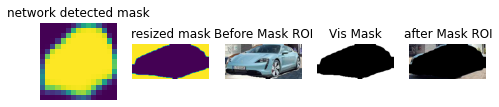

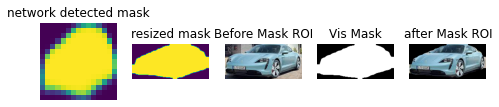

In [175]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(figsize=(8, 8), ncols=5, nrows=1)

ax1.set_title('network detected mask')
ax1.axis('off')
ax1.imshow(classMask)

ax2.set_title('resized mask')
ax2.axis('off')
ax2.imshow(scaled_classMask)


ax3.set_title('Before Mask ROI')
ax3.axis('off')
ax3.imshow(before_mask_roi)

ax4.set_title('Vis Mask')
ax4.axis('off')
ax4.imshow(vis_mask, cmap='gray')

ax5.set_title('after Mask ROI')
ax5.axis('off')
ax5.imshow(instance)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(figsize=(8, 8), ncols=5, nrows=1)

ax1.set_title('network detected mask')
ax1.axis('off')
ax1.imshow(classMask2)

ax2.set_title('resized mask')
ax2.axis('off')
ax2.imshow(scaled_classMask2)


ax3.set_title('Before Mask ROI')
ax3.axis('off')
ax3.imshow(before_mask_roi2)

ax4.set_title('Vis Mask')
ax4.axis('off')
ax4.imshow(vis_mask4, cmap='gray')

ax5.set_title('after Mask ROI')
ax5.axis('off')
ax5.imshow(instance4)

In [176]:
  dst = cv2.add(instance3, instance4)

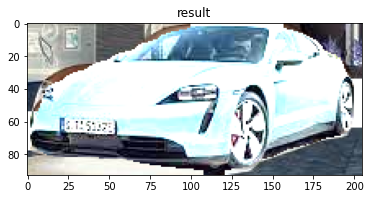

In [177]:
plt.figure(figsize=(6,6))
plt.title('result')
plt.imshow(dst)